In [1]:
import pandas as pd
from collections import defaultdict
import pickle
import gzip
import numpy as np
from collections import defaultdict
from multilabelexplanations import distance_functions
from scipy.spatial import distance

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
feat_matrices = defaultdict(list)
for dataset in ['yeast','woman']:
    pdist_matrix_squared = pd.read_csv("../dataset/%s_featspace_pdist.csv" % dataset, header=None).values
    feat_matrices[dataset]=pdist_matrix_squared

In [4]:
columns_ylist = {'woman': 'service', 'yeast': 'Class'}

## Dispersione attorno alla media

Per ogni istanza da spiegare seleziono i primi k vicini e ne calcolo la "dispersione" attorno al valore medio:
$$\frac{1}{k}\sum_{i=1}^k|\vec{v}_i-\bar{v}|^2$$

In [5]:
def neigh_sse(dataset):
    df_2e = pd.read_csv('../dataset/%s_2e.csv' % dataset)
    cols_Y = [col for col in df_2e.columns if col.startswith(columns_ylist[dataset])]
    cols_X = [col for col in df_2e.columns if col not in cols_Y]
    X2E = df_2e[cols_X]
    k=int(0.5*np.sqrt(len(X2E)))
    
    sse_list = []
    for instance in X2E.index.values:
        sampleKnn_feat_space = X2E.loc[pd.DataFrame(feat_matrices[dataset]).loc[instance].sort_values().index.values[0:k]]
        #norm_sampleKnn_feat_space = sampleKnn_feat_space.div(np.linalg.norm(sampleKnn_feat_space, axis=1), axis='index')
        #mean_squared_dist = sum(np.linalg.norm(norm_sampleKnn_feat_space - norm_sampleKnn_feat_space.mean(),axis=1)**2)/len(norm_sampleKnn_feat_space)
        mean_squared_dist = sum(np.linalg.norm(sampleKnn_feat_space - sampleKnn_feat_space.mean(),axis=1)**2)/len(sampleKnn_feat_space)
        
        sse_list.append(mean_squared_dist)
    return sse_list

0.5835401351201965


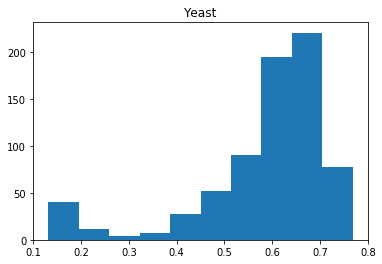

In [6]:
yeast_sse_list = neigh_sse('yeast')
hist(yeast_sse_list)
title('Yeast')
print(mean(yeast_sse_list))
show()

In [7]:
df_2e = pd.read_csv('../dataset/yeast_2e.csv')
cols_Y = [col for col in df_2e.columns if col.startswith(columns_ylist['yeast'])]
cols_X = [col for col in df_2e.columns if col not in cols_Y]
X2E_yeast = df_2e[cols_X]
mean_squared_dist = sum(np.linalg.norm(X2E_yeast - X2E_yeast.mean(),axis=1)**2)/len(X2E_yeast)
print(mean_squared_dist)

0.9986956764091441


6547.701568769927


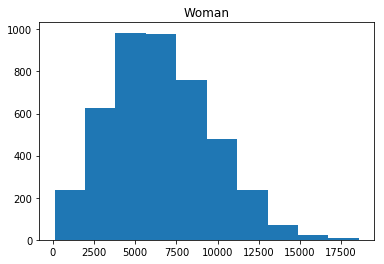

In [8]:
woman_sse_list = neigh_sse('woman')
hist(woman_sse_list)
print(mean(woman_sse_list))
title('Woman')
show()

In [9]:
df_2e = pd.read_csv('../dataset/woman_2e.csv')
cols_Y = [col for col in df_2e.columns if col.startswith(columns_ylist['woman'])]
cols_X = [col for col in df_2e.columns if col not in cols_Y]
X2E_woman = df_2e[cols_X]
mean_squared_dist = sum(np.linalg.norm(X2E_woman - X2E_woman.mean(),axis=1)**2)/len(X2E_woman)
print(mean_squared_dist)

13939.85117185598


## Distanza "mixed" dalla media

per ogni istanza da spiegare seleziono i primi k vicini e ne calcolo la MIXED DISTANCE media:
$$\frac{1}{k}\sum_{i=1}^kd_{mix}(\vec{v}_i-\bar{v})$$

In [10]:
def mixed_distance(x, y, n_var_cont, cdist, ddist):
    # type: (pandas.Series, pandas.Series, list, list, list, function, function) -> double
    """
    This function return the mixed distance between instance x and instance y
    :param x: np.array, instance 1
    :param y: np.array, instance 2
    :param discrete: slices dicrete
    :param continuous: slices continuos
    :param ddist: function, distance function for discrete variables
    :param cdist: function, distance function for continuos variables
    :return: double
    """
    wc=0.
    wd=0.
    cd=0.
    dd=0.
    n_var_disc = len(x[n_var_cont:])
    
    if n_var_cont != 0:
        wc = n_var_cont/(n_var_cont+n_var_disc)
        xc = x[0:n_var_cont]
        yc = y[0:n_var_cont]
        cd = cdist(xc, yc)
        
        
    if n_var_disc != 0:
        wd = n_var_disc/(n_var_cont+n_var_disc)
        xd = x[n_var_cont:]
        yd = y[n_var_cont:]
        dd = ddist(xd, yd)

    return wd * dd + wc * cd

In [11]:
#dizionario con chiave nome del dataset e valore una lista di liste, lista[0] = nomi var continue, lista[1] = nomi var discrete
with open('../dataset/dict_names.pickle', 'rb') as handle:
    columns_type_dataset = pickle.load(handle)

In [12]:
def create_dist_func(dataset):
    
    mydist = lambda x, y: mixed_distance(x, y, n_var_cont=len(columns_type_dataset[dataset][0]),
                     cdist=distance_functions.normalized_euclidean_distance,
                     ddist=distance.hamming)
    return mydist

In [13]:
def mixed_distance_from_mean(dataset):
    
    df_2e = pd.read_csv('../dataset/%s_2e.csv' % dataset)
    cols_Y = [col for col in df_2e.columns if col.startswith(columns_ylist[dataset])]
    cols_X = [col for col in df_2e.columns if col not in cols_Y]
    X2E = df_2e[cols_X]
    k=int(0.5*np.sqrt(len(X2E)))
    mydist = create_dist_func(dataset)
    
    mixed_distances_list = []
    for instance in X2E.index.values:
        #seleziono i primi k vicini:
        sampleKnn_feat_space = X2E.loc[pd.DataFrame(feat_matrices[dataset]).loc[instance].sort_values().index.values[0:k]]
        #ordino le colonne (voglio prima le var continue e poi quelle discrete)
        sorted_sampleKnn_feat_space = sampleKnn_feat_space[columns_type_dataset[dataset][0]+columns_type_dataset[dataset][1]]
        #calcolo il vettore medio
        mean_vec = sorted_sampleKnn_feat_space.mean()
        #calcolo la distanza mixed tra ogni vettore e il vettore medio
        mean_mixed_dist = sum(sorted_sampleKnn_feat_space.apply(lambda x: mydist(x.values,mean_vec.values), axis=1))/len(sorted_sampleKnn_feat_space)
        mixed_distances_list.append(mean_mixed_dist)
    return mixed_distances_list

In [14]:
mean_mixed_distance_from_mean_yeast = mixed_distance_from_mean('yeast')
mean_mixed_distance_from_mean_woman = mixed_distance_from_mean('woman')

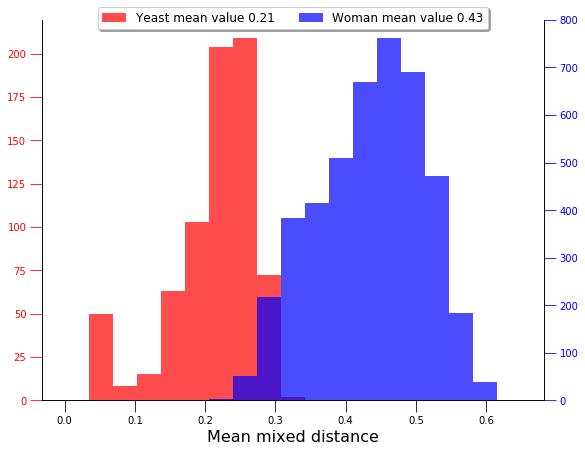

In [115]:
fig, ax1 = plt.subplots()
figsize(9,7)

n,bins,yeast_hist = ax1.hist(mean_mixed_distance_from_mean_yeast, label='Yeast mean value %.2f' % mean(mean_mixed_distance_from_mean_yeast),alpha=0.7,color='r',bins=linspace(0,0.65,20))
ax1.set_xlabel('Mean mixed distance',fontsize=16)
ax1.tick_params(axis='y', colors='red',size=12)
ax1.tick_params(axis='x',size=12)
ax2 = ax1.twinx()
n,bins,woman_hist = ax2.hist(mean_mixed_distance_from_mean_woman, label='Woman mean value %.2f'% mean(mean_mixed_distance_from_mean_woman),alpha=0.7,color='b',bins=linspace(0,0.65,20))

#ax1.xaxis


lns = yeast_hist+woman_hist
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=2, fancybox=True, shadow=True,fontsize=12)
ax2.tick_params(axis='y', colors='blue',size=12)
ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)

savefig('../fig/dispersion_hist.png', format='png', bbox_inches='tight')
show()